# Streaming 
In this exercise we want to test our keyword spotter on self recorded wav files containing some keywords. 

In [1]:
%matplotlib inline

In [2]:
import os
import tensorflow as tf
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from utility import smoothing, augment_audio

### Pre-trained model

In [3]:
## Load a pretrained model, you should choose a good one here out of the ones you have trained
checkpoint_path = './output/2023_09_13_09_08_40/saved_models/' 

In [4]:
## Load the model
if os.path.isdir(checkpoint_path):
    model = tf.keras.models.load_model(checkpoint_path)
    print('model loaded successfully')
else:
    print('could not find model')

model loaded successfully


In [5]:
# Print summary of trained model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 49, 1, 40)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 49, 1, 16)         1920      
                                                                 
 dropout_8 (Dropout)         (None, 49, 1, 16)         0         
                                                                 
 res_block_4 (ResBlock)      (None, 25, 1, 24)         9312      
                                                                 
 dropout_9 (Dropout)         (None, 25, 1, 24)         0         
                                                                 
 res_block_5 (ResBlock)      (None, 25, 1, 24)         10560     
                                                                 
 dropout_10 (Dropout)        (None, 25, 1, 24)        

### Deployment of keyword spotter

In [6]:
## Applying the kws to a given 1s audio chunk of data and returns a dictionary with the calculated scores
def apply_spotter(data=[], model=model):
    assert len(data)==fs
    mfccs = augment_audio(mode='',sig=data, fs=fs, l=l, s=s, n_mfccs=n_mfccs).reshape(1,49,40)
    prediction = model.predict(mfccs)[0]
    return {k:prediction[i] for i,k in enumerate(kws_all)}

In [7]:
## Load a recording containing some keywords. I provided this one but its more fun to try on your own recording
## I said: yes, no, what am I doing, go with short breaks in between
path_to_recording = './media/test.wav'
path_to_recording = './New Recording 3.wav'

audio = librosa.load(path_to_recording, sr=16000)[0]
ipd.Audio(audio, rate=16000)


In [8]:
## Divide the stream into chunks to simulate real streaming
chunksize = 4000 #num of samples for one window

audio_chunked = np.array([ audio[i*chunksize:(i+1)*chunksize] for i in range(0,len(audio)//chunksize)] )
audio_chunked.shape

(15, 4000)

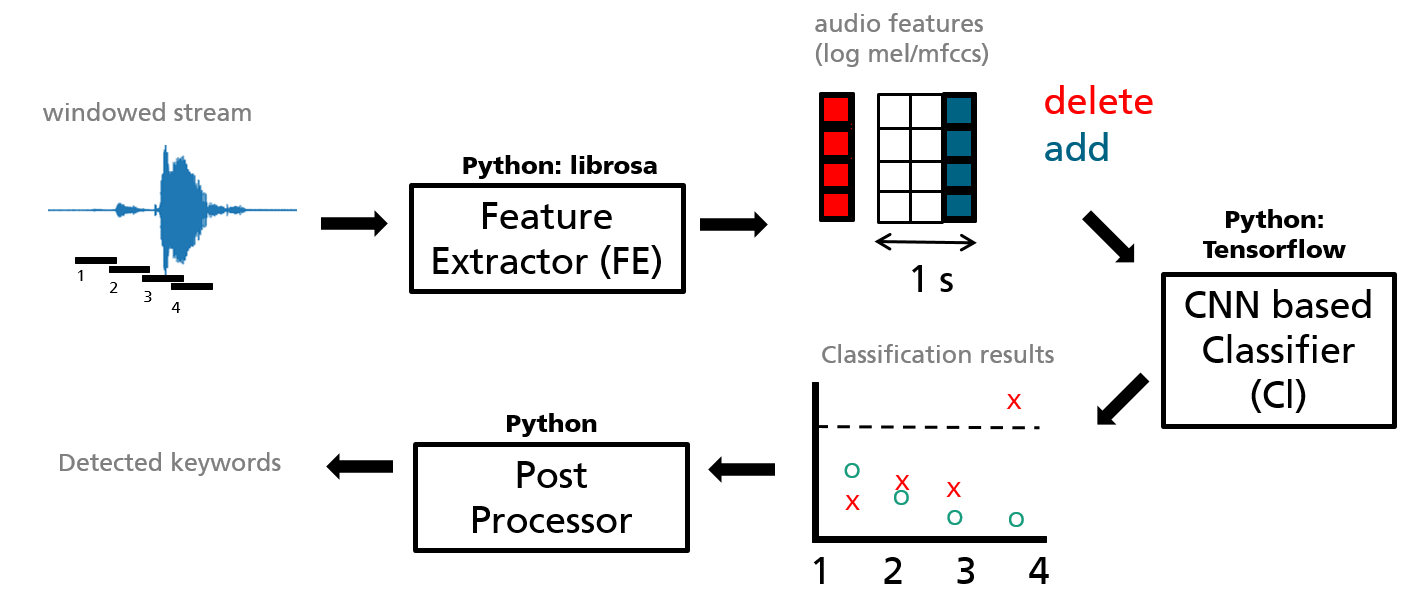

In [9]:
ipd.Image('./media/streaming_kws.png')

## Exercise

1. Create a $1s$ long audio array. For each chunk in audio_chunked, update the $1s$ long audio array and pass it to the apply_spotter function to evaluate the keyword spotter. Save the resulting probability scores into a vector "all_scores". Each entry of "all_scores" should contain $12$ probabilities, one for each keyword.
2. Plot the probabilities for all classes over time. How would you decide when a keyword was said based on the scores?
3. Understand what the smoothing function above does and use it to smooth the "all_scores" vector. Visualize the smoothed results. Are they better? Why?
4. Execute the notebook again, but with your own recording. You can use **audacity** to create a $.wav$ file. 

In [10]:
chunksize

4000

In [11]:
audio_1s = np.zeros(16000) 
all_scores = []
audio_1s[chunksize:].shape

(12000,)

In [12]:
audio_1s = np.zeros(16000) 
all_scores = []

for chunk in audio_chunked:
    audio_1s[0:16000-chunksize] = audio_1s[chunksize:]
    

## Hints

- Think about how you need to adjust the $1s$ long audio snippet each time a new chunk arrives.
- Here is a blueprint: 
```

audio_1s = np.zeros(16000)
all_scores = []

for chunk in audio_chunked:
    
    ## Throw out the oldest chunk
    audio_1s[0:16000-chunksize] = "xxx" 
    
    ## Append the latest chunk
    "xxx"  = chunk
    
    ## Apply the spotter
    scores = apply_spotter(audio_1s)
    
    ## Save scores for plotting
    all_scores.append([scores[key] for key in scores])
    
```
- In np. arrays you can use array[N:M] to get a new array with all the samples from N:M-1 of the old array.

## Solution

### E1

We drop the oldest chunk (left part of the input vector) and append the new chunk.

In [13]:
# %%capture --no-display
## Apply the model to the audio stream
audio_1s = np.zeros(16000)
all_scores = []

#print('chunksize', chunksize)
for chunk in audio_chunked:
    
    #print('chunk', chunk.shape, chunk)
    
    ## Throw out the oldest chunk
    audio_1s[0:16000-chunksize] = audio_1s[chunksize:]
    #print('audio_1s[chunksize:]', audio_1s[chunksize:].shape, audio_1s[chunksize:])
    
    ## Append the latest chunk
    audio_1s[16000-chunksize:] = chunk
    #print('audio_1s[16000-chunksize:]', audio_1s[16000-chunksize:].shape, audio_1s[16000-chunksize:])
    
    ## Apply the spotter
    scores = apply_spotter(audio_1s)
    
    ## Save scores for plotting
    all_scores.append([scores[key] for key in scores])
    
    

/home/participant/utility.py:124: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00541141 -0.00448999
 -0.0046494 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/home/participant/utility.py:124: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00550542 -0.00549577
 -0.00499942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/home/participant/utility.py:124: FutureWarning: Pass y=[0.         0.         0.         ... 0.00173759 0.00101445 0.00025321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, 

### E2 &  E3
We use a threshold whose value balances between false positives and false negatives. The problem is, there are some high but small width peaks that are obviously wrong. To avoid a false positive we also use the width of the peaks to decide wether a keyword was spoken. For example, this can  be done by using the area under the curve over a fixed amount of past time frames. The result (fig. 2) shows, that the narrow peaks can now be avoided by choosing a sufficiently high threshold.

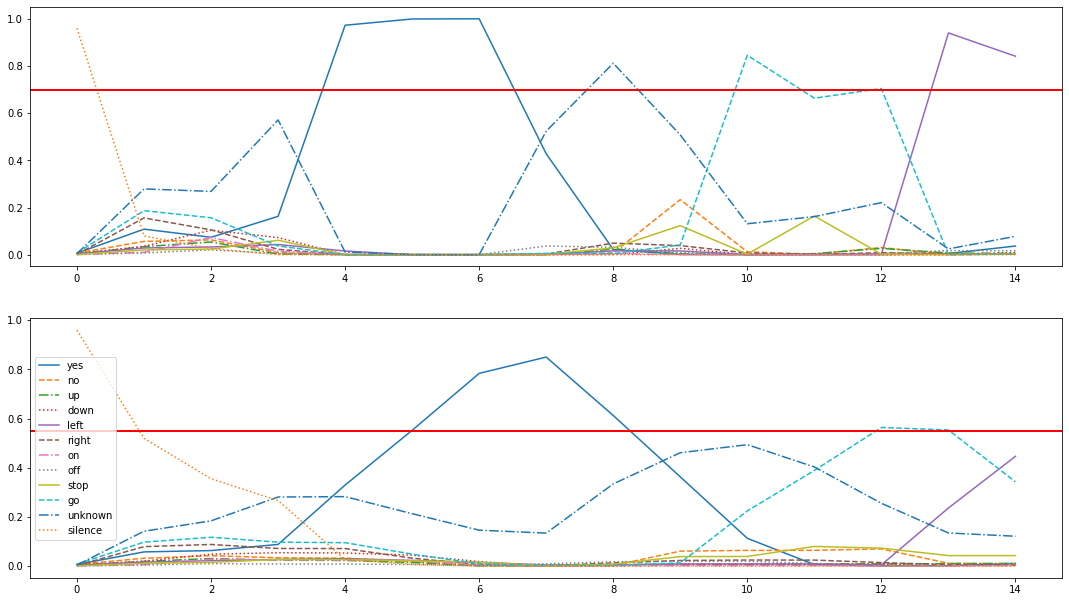

In [19]:
## plot the output probabilities
smoothing_level = 4

colors = ['red', 'green', 'blue', 'black', 'orange', 'brown', 'yellow', 'red', 'green', 'blue', 'black']
lines = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]

fig, axs = plt.subplots(2,)
fig.set_size_inches(18.5, 10.5)

hw_prob_smoothed = np.array(all_scores)

for i in range(len(hw_prob_smoothed[0])):
    axs[0].plot(hw_prob_smoothed[:,i], linestyle=lines[i])
    axs[0].axhline(y=.7, color='r')    
    
    axs[1].plot(smoothing(hw_prob_smoothed, smoothing_level)[:,i], label=kws_all[i], linestyle=lines[i])
    axs[1].axhline(y=.55, color='r')    

plt.legend()

In [15]:
ipd.Audio(audio, rate=16000)

In [16]:
# Code to upload file via a small widget.
# The uploaded file should apprea at the same folder with this notebook.

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

# Create a FileUpload widget
upload = widgets.FileUpload(
    accept='',  # Accepted file types (empty string means all)
    multiple=False  # Set to True if you want to allow multiple file uploads
)

# Display the widget
display(upload)

def on_upload_change(change):
    uploaded_filename = list(upload.value.keys())[0]
    uploaded_filedata = upload.value[uploaded_filename]['content']

    # Save the uploaded file to a desired location or process it
    with open(uploaded_filename, 'wb') as f:
        f.write(uploaded_filedata)

    print(f"Uploaded file: {uploaded_filename}")
    clear_output()

# Attach the event handler to the widget's value change
upload.observe(on_upload_change, names='_counter')

FileUpload(value={}, description='Upload')

In [17]:
## Load a recording containing some keywords. I provided this one but its more fun to try on your own recording
## I said: yes, no, what am I doing, go with short breaks in between
path_to_recording = 'New Recording 3.wav'

audio = librosa.load(path_to_recording, sr=16000)[0]
ipd.Audio(audio, rate=16000)
audio_chunked = np.array([ audio[i*chunksize:(i+1)*chunksize] for i in range(0,len(audio)//chunksize)] )
audio_chunked.shape

audio_1s = np.zeros(16000)
all_scores = []

#print('chunksize', chunksize)
for chunk in audio_chunked:
    
    
    ## Throw out the oldest chunk
    audio_1s[0:16000-chunksize] = audio_1s[chunksize:]
    
    ## Append the latest chunk
    audio_1s[16000-chunksize:] = chunk
    
    ## Apply the spotter
    scores = apply_spotter(audio_1s)
    
    ## Save scores for plotting
    all_scores.append([scores[key] for key in scores])
    

/home/participant/utility.py:124: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00541141 -0.00448999
 -0.0046494 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/home/participant/utility.py:124: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00550542 -0.00549577
 -0.00499942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/home/participant/utility.py:124: FutureWarning: Pass y=[0.         0.         0.         ... 0.00173759 0.00101445 0.00025321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, 

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

upload = widgets.FileUpload(
accept="",
multiple=False)

display(upload)

def on_upload_change(change):
     uploaded_filename = list(upload.value.keys())[0]
     uploaded_filedata = upload.value[uploaded_filename]['content']

     with open(uploaded_filename, "wb") as f:
         f.write(uploaded_filedata)

     print(f"Uploaded file: {uploaded_filename}")
     clear_output()

upload.observe(on_upload_change, names="_counter")

FileUpload(value={}, description='Upload')